In [1]:
from BuildModel import *
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [11]:
def GetRandomGoodUser():
    return np.random.choice([user for user in DB.getActiveUsers() if len(DB.contestHistory[user]) > 50])

In [3]:
def GetUsers(random_users=5):
    users = [GetRandomGoodUser() for i in range(random_users)]
    users.extend(['Okrut', 'Goorkiewicz', 'tourist'])
    return users

In [4]:
def MyTestUserSklearn(user, ModelType, ax, verbose = True, save = True, **kwargs):
    DF = pd.DataFrame(ReadUserDatabase())
    DF = DF[DF["user"] == user].drop(["user", "country"], axis=1)

    contestList = DB.getUserContests(user)
    assert len(contestList) > 20

    xs, ys = [], []
    n = len(contestList)

    for i in range(n - 20):
        s = i + 20
        if DF.iloc[s]['contest id'] < 1200:
            if verbose:
                print('Skipping contest of id %d' % DF.iloc[s]['contest id'])
            continue

        train_df = DF[i:s]
        X, y = train_df.drop('target', axis=1), train_df['target']
        model = ModelType(**kwargs).fit(X, y)
        pred = model.predict([DF.iloc[s].drop('target')])[0]
        
        if verbose:
            print('done %d, left %d' % (i, n - 20 - i - 1))
        
        xs.append(pred)
        ys.append(DF.iloc[s]['target'])
    
    xs = np.array(xs)
    ys = np.array(ys)

    zs = abs(xs - ys)
    avgErr = sum(zs) / len(zs)
    if verbose:
        print('Average error is %.10lf' % avgErr)

    b, m = np.polynomial.polynomial.polyfit(xs, ys, 1)
    ax.plot(xs, ys, '.')
    ax.plot(xs, b + m * xs, 'r-')
    ax.plot(xs, xs, 'b-')
    ax.set_title(user)
    ax.set_xlabel('Expected change by Predictor')
    ax.set_ylabel('True change')

    return avgErr

In [5]:
params = {
    RandomForestRegressor: {
        'n_estimators': 20,
        'max_features': 3
    },
    AdaBoostRegressor: {
        'n_estimators': 20
    },
    KNeighborsRegressor: {
        "n_neighbors": 5
    },
    GradientBoostingRegressor: {
        
    },
    
}

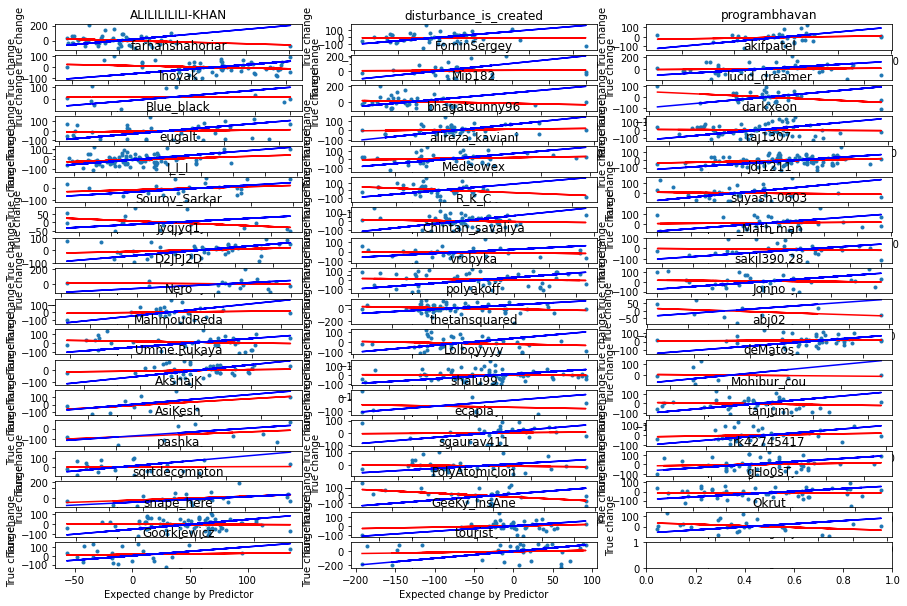

In [13]:
users = GetUsers(50)
users_len = len(users)

cols = 3
rows = int(np.ceil(users_len / cols))
fig, axs = plt.subplots(rows, cols, figsize=(15, 10))

# model = RandomForestRegressor
model = AdaBoostRegressor
# model = KNeighborsRegressor 
# model = GradientBoostingRegressor

for ax, user in zip(axs.flatten(), users):
    MyTestUserSklearn(user, model, ax, verbose=False, save=False, **params[model])

In [6]:
def TestModel(model):
    users = GetUsers()
    errs = np.empty(len(users))
    
    for i, user in enumerate(users):
        avg_err = TestUserSklearn(user, model, verbose=False, save=True, **params[model])
        errs[i] = avg_err
        
    return errs.min(), errs.max(), errs.mean(), errs.std()

KeyboardInterrupt: 

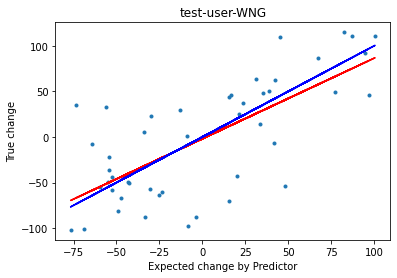

In [9]:
# models = params.keys()
models = [GradientBoostingRegressor, AdaBoostRegressor]
data = []
for model in models:
    data.append((model.__name__, *TestModel(model)))
data

In [83]:
data_df = pd.DataFrame(data, columns=['model', 'min', 'max', 'mean', 'std'])
data_df

,model,min,max,mean,std
0,GradientBoostingRegressor,21.364943,45.246843,35.902202,7.459140
1,AdaBoostRegressor,26.505322,69.500000,43.475675,15.784772
